In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import pickle
import time

from matplotlib import pyplot as plt

from scipy import stats
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import concurrent.futures
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# Custom imports
from GEMS_TCO import orbitmap
from GEMS_TCO import kernels

In [2]:
df = pd.read_csv("C:\\Users\\joonw\\TCO\\data_engineering\\data_2024\\data_24_07_0131_N510_E110120.csv")
instance = orbitmap.MakeOrbitdata(df, 5,10,110,120)

# Load the dictionary from the pickle file
filepath = "C:\\Users\\joonw\\TCO\\data_engineering\\data_2024\\sparse_cen_map24_01.pkl"

with open(filepath, 'rb') as pickle_file:
    coarse_dict_24_1 = pickle.load(pickle_file)

sample_df = coarse_dict_24_1['y24m01day01_hm02:12']

In [24]:
rho_lat = 20
rho_lon = 20
lat_n = sample_df['Latitude'].unique()[::rho_lat]
lon_n = sample_df['Longitude'].unique()[::rho_lon]

print(len(lat_n))
print(len(lon_n))

5
10


In [25]:
# Set coarse coordinates
coarse_dicts = {}

years = ['2023','2024']
for year in years:
    for month in range(1, 13):  # Iterate over all months
        filepath = f"C:\\Users\\joonw\\TCO\\data_engineering\\data_{year}\\sparse_cen_map{year[2:]}_{month:02d}.pkl"
        with open(filepath, 'rb') as pickle_file:
            loaded_map = pickle.load(pickle_file)
            for key in loaded_map:
                tmp_df = loaded_map[key]
                coarse_filter = (tmp_df['Latitude'].isin(lat_n)) & (tmp_df['Longitude'].isin(lon_n))
                coarse_dicts[f"{year}_{month:02d}_{key}"] = tmp_df[coarse_filter].reset_index(drop=True)

        print(f"Finished processing {year} {month}.")


Finished processing 2023 1.
Finished processing 2023 2.
Finished processing 2023 3.
Finished processing 2023 4.
Finished processing 2023 5.
Finished processing 2023 6.
Finished processing 2023 7.
Finished processing 2023 8.
Finished processing 2023 9.
Finished processing 2023 10.
Finished processing 2023 11.
Finished processing 2023 12.
Finished processing 2024 1.
Finished processing 2024 2.
Finished processing 2024 3.
Finished processing 2024 4.
Finished processing 2024 5.
Finished processing 2024 6.
Finished processing 2024 7.
Finished processing 2024 8.
Finished processing 2024 9.
Finished processing 2024 10.
Finished processing 2024 11.
Finished processing 2024 12.


In [26]:
key_list = list(coarse_dicts.keys())
train_set = []
test_set = []
for i in range(len(coarse_dicts)):
    if i<= 4539:
        train_set.append(coarse_dicts[key_list[i]]) 
    else:
        test_set.append(coarse_dicts[key_list[i]]) 

train_set = pd.concat(train_set, axis=0, ignore_index=True)
test_set = pd.concat(test_set, axis=0, ignore_index=True)

In [10]:
# CNN Model for Spatial Feature Extraction
class FeatureExtractorCNN(nn.Module):
    def __init__(self, cnn_channels, output_size):
        super(FeatureExtractorCNN, self).__init__()
        self.conv1 = nn.Conv2d(cnn_channels, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16,  32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(64 * 5 * 10, output_size)  # Adjust based on grid size (5x10 here)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Custom Dataset for Ozone Data
class OzoneDataset(Dataset):
    def __init__(self, data, num_latitude, num_longitude, daily_cycle_len, monthly_cycle_len, three_month_cycle_len):
        self.data = data
        self.num_latitude = num_latitude
        self.num_longitude = num_longitude
        self.daily_cycle_len = daily_cycle_len
        self.monthly_cycle_len = monthly_cycle_len
        self.three_month_cycle_len = three_month_cycle_len

        # Cache unique latitude/longitude indices for faster grid construction
        self.latitudes = sorted(data['Latitude'].unique())
        self.longitudes = sorted(data['Longitude'].unique())
        self.time_steps = sorted(data['Hours_elapsed'].unique())
        self.lat_lon_map = {
            (row['Latitude'], row['Longitude']): (self.latitudes.index(row['Latitude']), self.longitudes.index(row['Longitude']))
            for _, row in data.iterrows()
        }

        # Prepare data for sequences
        self.prepared_data = self.prepare_data()

    def prepare_data(self):
        X_daily, X_monthly, X_three_month, y = [], [], [], []
        for i in range(len(self.time_steps) - self.three_month_cycle_len):
            daily_seq, monthly_seq, three_month_seq = [], [], []

            for t in range(i, i + self.three_month_cycle_len):
                sub_data = self.data[self.data['Hours_elapsed'] == self.time_steps[t]]
                grid = np.zeros((self.num_latitude, self.num_longitude))
                
                for _, row in sub_data.iterrows():
                    lat_idx, lon_idx = self.lat_lon_map[(row['Latitude'], row['Longitude'])]
                    grid[lat_idx, lon_idx] = row['ColumnAmountO3']

                if t < i + self.daily_cycle_len:
                    daily_seq.append(grid)
                if t < i + self.monthly_cycle_len:
                    monthly_seq.append(grid)
                three_month_seq.append(grid)

            X_daily.append(torch.tensor(np.array(daily_seq), dtype=torch.float32))
            X_monthly.append(torch.tensor(np.array(monthly_seq), dtype=torch.float32))
            X_three_month.append(torch.tensor(np.array(three_month_seq), dtype=torch.float32))
            y.append(torch.tensor(np.array(three_month_seq[-1]), dtype=torch.float32))  # Target is last grid in the sequence

        return X_daily, X_monthly, X_three_month, y

    def __len__(self):
        return len(self.prepared_data[0])

    def __getitem__(self, idx):
        X_daily, X_monthly, X_three_month, y = self.prepared_data
        return X_daily[idx], X_monthly[idx], X_three_month[idx], y[idx]

# Multi-Scale LSTM for Temporal Modeling
class MultiScaleLSTM(nn.Module):
    def __init__(self, cnn_channels, cnn_output_size, lstm_hidden_size, lstm_num_layers=1, lstm_dropout=0.25):
        super(MultiScaleLSTM, self).__init__()
        self.cnn = FeatureExtractorCNN(cnn_channels, cnn_output_size)
        self.lstm_daily = nn.LSTM(cnn_output_size, lstm_hidden_size, num_layers=lstm_num_layers, dropout=lstm_dropout, batch_first=True)
        self.lstm_monthly = nn.LSTM(cnn_output_size, lstm_hidden_size, num_layers=lstm_num_layers, dropout=lstm_dropout, batch_first=True)
        self.lstm_three_month = nn.LSTM(cnn_output_size, lstm_hidden_size, num_layers=lstm_num_layers, dropout=lstm_dropout, batch_first=True)
        # self.fc = nn.Linear(lstm_hidden_size * 3, 1)
        self.fc = nn.Linear(lstm_hidden_size * 3, 5 * 10)

    def forward(self, X_daily, X_monthly, X_three_month):
        def extract_features(X_seq):
            batch_size, seq_len, height, width = X_seq.shape
            # Process each timestep with CNN
            features = [self.cnn(X_seq[:, t].unsqueeze(1)) for t in range(seq_len)]
            return torch.stack(features, dim=1)  # Shape: [batch_size, seq_len, cnn_output_size]

        # Extract spatial features for each sequence
        daily_features = extract_features(X_daily)
        monthly_features = extract_features(X_monthly)
        three_month_features = extract_features(X_three_month)

        # Process temporal features using LSTMs
        lstm_out_daily, _ = self.lstm_daily(daily_features)
        lstm_out_monthly, _ = self.lstm_monthly(monthly_features)
        lstm_out_three_month, _ = self.lstm_three_month(three_month_features)

        # Concatenate the final outputs from each LSTM
        combined_features = torch.cat((lstm_out_daily[:, -1, :], lstm_out_monthly[:, -1, :], lstm_out_three_month[:, -1, :]), dim=1)

        output = self.fc(combined_features)
        output = output.view(-1, 5, 10)  # Reshape to grid dimensions

        # Final prediction
        return output


In [102]:

### 
# Parameters
num_latitude = 5
num_longitude = 10
cnn_channels = 1  # Grayscale-like input
cnn_output_size = 64  # Number of features extracted by CNN
daily_cycle_len = 8
monthly_cycle_len = 24    #240
three_month_cycle_len = 60  # 60 to 40
lstm_hidden_size = 128 # 128
# Prepare the test data


# Initialize the model architecture
model = MultiScaleLSTM(cnn_channels, cnn_output_size, lstm_hidden_size)
# Load the saved model weights
model_path = f'C:\\Users\\joonw\\TCO\\GEMS_TCO-1\\models\\saved_models\\cnn_lstm_{5}_{10}2.pth'
model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
model.eval()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_35788\2108277220.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


MultiScaleLSTM(
  (cnn): FeatureExtractorCNN(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc): Linear(in_features=3200, out_features=64, bias=True)
  )
  (lstm_daily): LSTM(64, 128, batch_first=True, dropout=0.25)
  (lstm_monthly): LSTM(64, 128, batch_first=True, dropout=0.25)
  (lstm_three_month): LSTM(64, 128, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=384, out_features=50, bias=True)
)

In [103]:
# Load dataset # Replace with your actual test data
data = test_set
dataset = OzoneDataset(data, num_latitude, num_longitude, daily_cycle_len, monthly_cycle_len, three_month_cycle_len)
test_dataloader = DataLoader(dataset, batch_size=16, shuffle=False)



# Evaluate the model
total_loss = 0.0
criterion = nn.MSELoss()

pred_set = []
y_set = []

with torch.no_grad():  # Disable gradient calculation
    for X_daily, X_monthly, X_three_month, y in test_dataloader:
        # Move data to GPU
        X_daily, X_monthly, X_three_month, y = X_daily.to(device), X_monthly.to(device), X_three_month.to(device), y.to(device)
        
        # Debugging print statements
        print(f"X_daily: {X_daily}")
        print(f"X_monthly: {X_monthly}")
        print(f"X_three_month: {X_three_month}")
        
        # Get predictions
        predictions = model(X_daily, X_monthly, X_three_month)
        
        # Debugging print statements
        print(f"Predictions: {predictions}")
        
        pred_set.append(predictions.cpu().numpy())
        y_set.append(y.cpu().numpy())
        
        # Calculate loss
        loss = criterion(predictions, y)
        total_loss += loss.item()

# Calculate average loss
average_loss = total_loss / len(test_dataloader)
print(f"Test Loss: {average_loss:.4f}")

X_daily: tensor([[[[262.4115, 258.3936, 258.5993,  ..., 260.8143, 261.2454, 258.9717],
          [257.6731, 259.1051, 260.1249,  ..., 262.9731, 255.4933, 256.8164],
          [256.8449, 256.0201, 252.4416,  ..., 262.0508, 260.4314, 260.9294],
          [257.0623, 261.5290, 259.8099,  ..., 263.3988, 257.6011, 257.1995],
          [266.7615, 258.5428, 258.0803,  ..., 261.6839, 260.8623, 261.0636]],

         [[262.2131, 264.3352, 262.9725,  ..., 260.5257, 258.3232, 258.6122],
          [262.8213, 263.8751, 259.9356,  ..., 262.3091, 257.7821, 260.2404],
          [261.9356, 262.4006, 262.6501,  ..., 260.5384, 259.6779, 262.3116],
          [261.9567, 262.9224, 265.1784,  ..., 255.9883, 263.8277, 266.7191],
          [264.6672, 263.3545, 262.5573,  ..., 261.3379, 251.8593, 264.1129]],

         [[262.1053, 267.0493, 262.4770,  ..., 253.7676, 254.7827, 257.8717],
          [261.7202, 261.4161, 267.0836,  ..., 265.0069, 260.8302, 262.8058],
          [261.4396, 259.9506, 261.4116,  ..., 261.

In [104]:
pred_set[0]==pred_set[5]

array([[[ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True]],

       [[ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True]],

       [[ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  

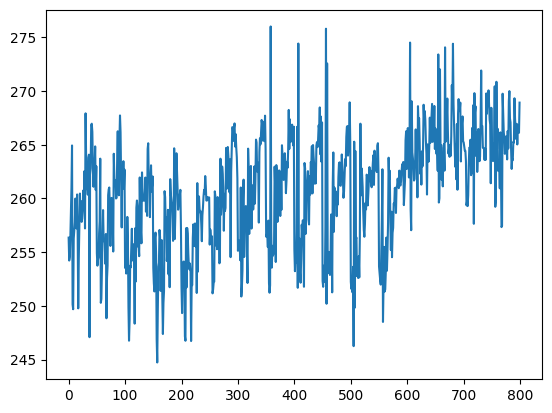

In [73]:
plt.plot(np.array(y_set[0]).flatten())

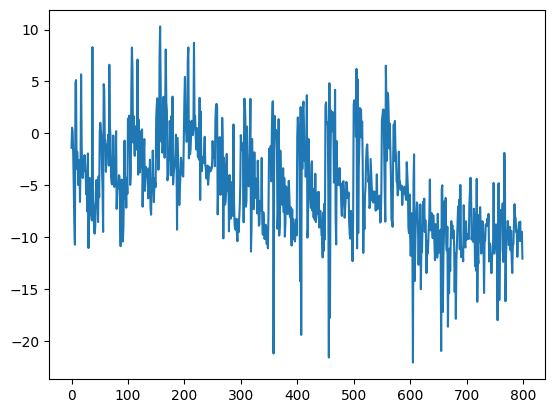

In [72]:
plt.plot(np.array(a[0]).flatten())

In [95]:
a = [a/b for a,b in zip(pred_set,y_set)]

for i in range(16):
    print(np.var(np.array(y_set[i])))

27.511545
10.90265
10.178003
14.080658
12.9837475
10.693777
11.446558
11.141376
14.180694
10.465701
17.068474
21.222496
10.443622
8.180663
8.590127
10.208828


In [99]:
for i in range(16):
    print(np.mean(np.array(a[i])))

98.027306
97.22426
97.76068
97.21873
96.773926
98.05461
100.28621
101.817635
101.556915
103.74682
104.338715
103.60341
101.77696
100.578926
101.22014
102.558205


In [39]:
dif = y-predictions
dif1 = dif[0]

print(np.var(np.array(dif[0])))
print(np.var(np.array(dif[1])))
print(np.var(np.array(dif[2])))


print(np.mean(np.array(dif[0])))
print(np.mean(np.array(dif[1])))
print(np.mean(np.array(dif[2])))





13.4885645
8.380328
11.619824
-18.457647
-19.033594
-19.572426


tensor([[[-16.5642, -14.3911, -14.5196, -17.3286, -17.2327, -19.0561, -18.3642,
           -9.0997, -11.9155, -10.1181],
         [-17.2241, -15.4023, -19.4818, -20.8486, -20.0565, -22.0259, -21.0132,
          -18.7089, -16.9035, -19.9438],
         [-15.3532, -16.8872, -15.1712, -21.4079, -24.4930, -23.2649, -20.2344,
          -20.7902, -24.0043, -22.3426],
         [-14.3426, -15.2392, -15.7518, -23.3384, -18.6336, -25.1395, -19.1540,
          -14.7010, -21.1771, -22.9350],
         [-15.5358, -14.3982, -16.2794, -17.3481, -18.2514, -19.7248, -24.8307,
          -20.9688, -17.9422, -23.0435]],

        [[-18.3868, -18.8451, -13.9728, -17.9263, -14.9850, -19.0843, -19.8018,
          -13.5612, -16.8185, -17.4845],
         [-18.0779, -15.6340, -20.6552, -21.8904, -19.6245, -19.3226, -21.1277,
          -17.2182, -18.5264, -20.5373],
         [-17.9099, -15.7692, -22.7949, -23.0540, -23.2538, -16.9902, -23.4283,
          -23.3714, -23.3524, -21.1783],
         [-14.9998, -14.8890, 